# First we generate an SDE

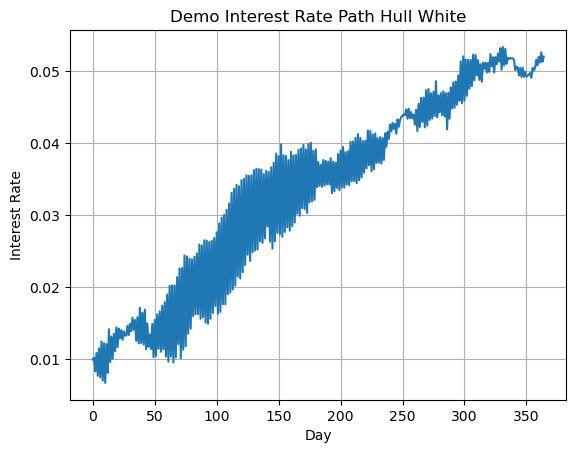

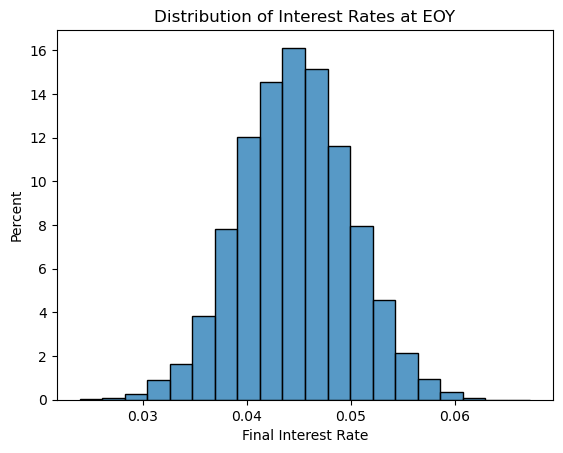

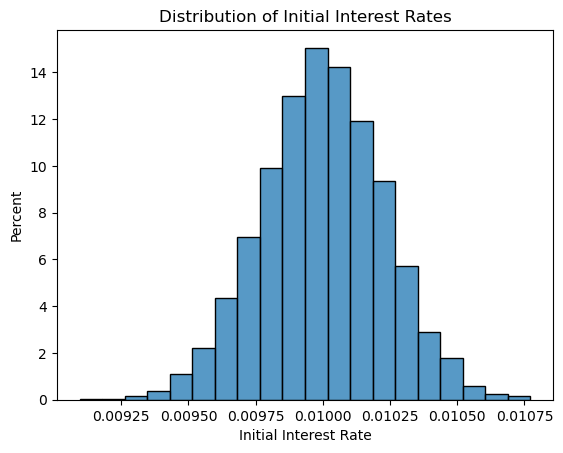

In [ ]:
from numpy.random import normal as normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from random import choices as draw
from itertools import chain

## Vasicek Model
theta = 0.05 # Stasis rate 5%
alpha = 4 # Juiced Return Rate
sigma = 0.015
dt = 1/365 # Daily updates

hw = lambda r: r + alpha*(theta - r)*dt + sigma*np.sqrt(dt)*normal()
r0 = 0.01 # Initial interest rate of 1% means that we will see an expected drift up

rs = [r0]
for i in range(364):
    rs.append(hw(rs[i-1]))

plt.plot(rs)
plt.title('Demo Interest Rate Path Vasicek')
plt.ylabel('Interest Rate')
plt.xlabel('Day')
plt.grid()
plt.show()

## Generate 2000 paths for an empirical set of end points
def generatePath():
    rs = [normal(r0, sigma**2)]
    for i in range(364):
        rs.append(hw(rs[i-1]))
    return rs

paths = [generatePath() for i in range(10000)]
end_data = [path[-1] for path in paths]
sb.histplot(end_data, bins = 20, stat = 'percent');
plt.xlabel('Final Interest Rate');
plt.title('Distribution of Interest Rates at EOY');
plt.show()

start_data = [path[0] for path in paths]
sb.histplot(start_data, bins = 20, stat = 'percent');
plt.xlabel('Initial Interest Rate');
plt.title('Distribution of Initial Interest Rates');
plt.show()

# Then we create the drift fitting models, and SDE Solver

In [ ]:
'''
I choose to use two models in this fit, one forward model, which will replicate the Vasicek Structure, and hopefully recover the correct parameters,
and one reversewise flexible Neural Network to handle the nonlinearities and time dependence in the structure.
'''
# SDE generator from drift function and empirical IVs.
def SDESolve(u, pi, gamma = sigma, N = 60, direction='f'):  # N is a proxy for dt and means that there's no risk of passing a dt that doesn't properly split the space.
    t_s = np.arange(N)/(N-1)
    if direction == 'b':
        t_s = reverse(t_s)
    dt = np.abs(t_s[1]-t_s[0])
    
    paths = []
    for x0 in pi:
        x = [x0]
        for i, t in enumerate(t_s[:-1]):
            x.append(x[i] + u(x[i], t)*dt + np.sqrt(dt)*gamma*normal())
        paths.append(np.asmatrix([x,t_s]).T)
        
    return paths

# Reverses a set of paths, flipping the time indexing
def reverse(path):
    path = np.flip(path, axis=0)
    return path


# Forward Model,
# We maximise the likelihood by fitting a  Vasicek model, this can be done by least squares
def leastSquares(x: np.matrix, y:np.matrix):
    return np.linalg.inv(x.T@x)@x.T@y

def regressVasicek(data: list[np.matrix], verbose = True):
    # We treat the (discretized) Vasicek model as:
    # r_t+1 = alpha*(theta - r_t)dt + sigma*sqrt(dt)*N(0,1) + r_t -> 
    # (r_t+1 - r_t)/dt = alpha*(theta - r_t) + eps
    # (r_t+1 - r_t)/dt = ax + b + eps | a = -alpha, b = alpha*theta
    # We can regress a and b, and given a known dt estimate out alpha, theta and sigma
    # Since the noise is i.i.d this is likelihood maximising
    x = np.concatenate([entry[:-1] for entry in data], axis = 0)
    dt = np.abs(x[1,1] - x[0,1])
    x = np.concatenate([x[:,0],np.ones_like(x[:,0])], axis = 1)
    y = np.concatenate([np.diff(entry[:,0], axis=0)/dt for entry in data],axis=0)      # Targets implied drift:  (x_{t}-x{t+1})/dt

    beta = leastSquares(x,y) # type: ignore
    a = beta[0,0] # ax + b = y
    b = beta[1,0]

    alpha = -a
    theta = b/alpha

    u_f = lambda r,t: alpha*(theta - r)

    if verbose:
        return u_f, alpha, theta
    return u_f


# Backwards Model
# Since the backwards model needs to handle time dependence and the nonlinearity of the reversed process we make this a simple neural network, looking at the last point and the time
import torch as th
from torch.utils.data import Dataset, DataLoader, RandomSampler
class HWDataSet(Dataset):
    def __init__(self, inputPaths):
        x = np.concatenate([entry[:-1] for entry in inputPaths], axis = 0)         # Arguments are last state and reverse time (In reversed view, X = [0.04, 0.039, 0.042, ...;    ->  y = [-0.001, -0.003, ...]) s.t. the trained model will predict backwards drift from future state.
                                                                                   #                                                                   1   , 0.9  , 0.8  , ...].T) ->   
        dt = np.abs(x[1,1] - x[0,1])
        y = np.concatenate([np.diff(entry[:,0], axis=0)/dt for entry in inputPaths],axis=0)      # Targets implied drift:  (x_{t}-x{t+1})/dt
        self.x = th.tensor(x, dtype=th.float32)
        self.y = th.tensor(y, dtype=th.float32)

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
class backwardsModel(th.nn.Module):
    def __init__(self, dim = 100):
        super().__init__()
        self.dim = dim
        self.inputDim = 2
        self.outputDim = 1
        self.learning_rate = 1e-3
        self.setup()

    def setup(self):
        self.predictor = th.nn.Sequential(
            th.nn.Linear(self.inputDim, self.dim),
            th.nn.Linear(self.dim, round(self.dim/2)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/2), round(self.dim/4)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/4), round(self.dim/8)),
            th.nn.LeakyReLU(),
            th.nn.Linear(round(self.dim/8), self.outputDim),
        )

    def forward(self, x):
        x = self.predictor(x)
        return x

    def fit(self, inputPaths, epochs = 32, batch_size = None):
        self.train()
        dataset =  HWDataSet(inputPaths)
        if batch_size is None:
            batch_size = int(np.ceil(dataset.__len__()/epochs))
        
        sampler = RandomSampler(dataset, replacement=True)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

        loss_fn = th.nn.MSELoss()   # Assuming markov noise, p(path) = p(x_T)*p(x_T-1|x_T)*p(x_T-2|x_T-1) etc. -> p(path) ∝ Πp(x_T|x_{T-1}), and given roughly gaussian noise for small increments s.t. x_n ~ N(dt*u(x_{n+1},t_{n+1}),gamma) + x_n+1
                                    # p(x_n|x_{n-1}) ∝ e^(-(x_n - x_{n+1})^2)
                                    # So PMLE to allow us to use individual samples instead of whole linked paths to regress (for faster run at cost of exactness): log(p(path)) ∝ Sum((x_n-x_{n+1}) - dt*u_hat(x_{n+1},t_{n+1})^2) = Sum((x_n-x_{n+1})/dt - u_hat(x_{n+1},t_{n+1})^2)
                                    # Which we can optimize over elementwise.
        
        optimizer = th.optim.Adam(self.parameters(), lr=self.learning_rate) # ADAM might fit too fast / overfit / find extremely steep or unstable minima in weight space.
                                                                            # Previous runs with ADAM do show much faster initial finding of the correct properties, though stagnation occurs
        for epoch in np.arange(epochs):
            for xb, yb in loader: 
                optimizer.zero_grad()
                pred = self(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
            #print(f"epoch {epoch}, loss={loss.item():.4f}")
    
    @th.no_grad()
    def u_b(self, x,t):
        self.eval()
        X_np = np.asmatrix([x,t])
        X_tensor = th.tensor(X_np, dtype=th.float32)
        preds = self(X_tensor)
        return preds.cpu().numpy().item()

# Finally we Fit The Model

In [ ]:
## Now we Drop The Pathwise info completely, and keep only the edges
paths.clear()
frames = {'start': start_data, 'end': end_data}

## And fit the Schrodinger Bridge by iterated MLE
alpha_init = 1
theta_init = 1
alphas = [alpha_init]
thetas = [theta_init]

u_f0 = lambda r, t: alpha_init*(theta_init - r)
u_forwards = u_f0

backModel = backwardsModel()

numSamples = 500
schrodSteps = 25
for i in range(1,schrodSteps+1):
    forwardPaths = SDESolve(u=u_forwards, pi=draw(frames['start'], k = numSamples), N=60, direction='f')
    backModel.fit([reverse(path) for path in forwardPaths])
    u_backwards = backModel.u_b

    backwardsPaths = SDESolve(u=u_backwards, pi=draw(frames['end'], k = numSamples), N=60, direction='b')
    u_forwards, alpha, theta = regressVasicek([reverse(path) for path in backwardsPaths], verbose=True) # type: ignore
    alphas.append(alpha)
    thetas.append(theta)
    print(f"{i}: alpha: {alpha}, theta: {theta}")


1: alpha: 0.9895237352438414, theta: 0.4473167647818915
2: alpha: 1.1819187479924471, theta: 0.14985862771409572
3: alpha: 3.4452116433140265, theta: 0.05179682460034889
4: alpha: 4.398578511862961, theta: 0.04724195480438415
5: alpha: 4.906419598864766, theta: 0.04622853528030268
6: alpha: 4.262765454757121, theta: 0.04513166374141169
7: alpha: 4.272902307957961, theta: 0.044434502632017404
8: alpha: 4.02182587343476, theta: 0.044067251157071344
9: alpha: 3.69733012655335, theta: 0.04466415031807239
10: alpha: 3.497202604102763, theta: 0.044834537060360134
11: alpha: 3.8376338409193815, theta: 0.04587005483874179
12: alpha: 4.203261526112405, theta: 0.04652496986541806
13: alpha: 4.598738441885338, theta: 0.04536945630309993
14: alpha: 4.357956283684996, theta: 0.04433368535562604
15: alpha: 4.185714662595139, theta: 0.044224832711749304
16: alpha: 3.9619315849606846, theta: 0.04502652647991931
17: alpha: 4.147071987966759, theta: 0.04578789400030497
18: alpha: 4.561402619819545, thet

# Plotting

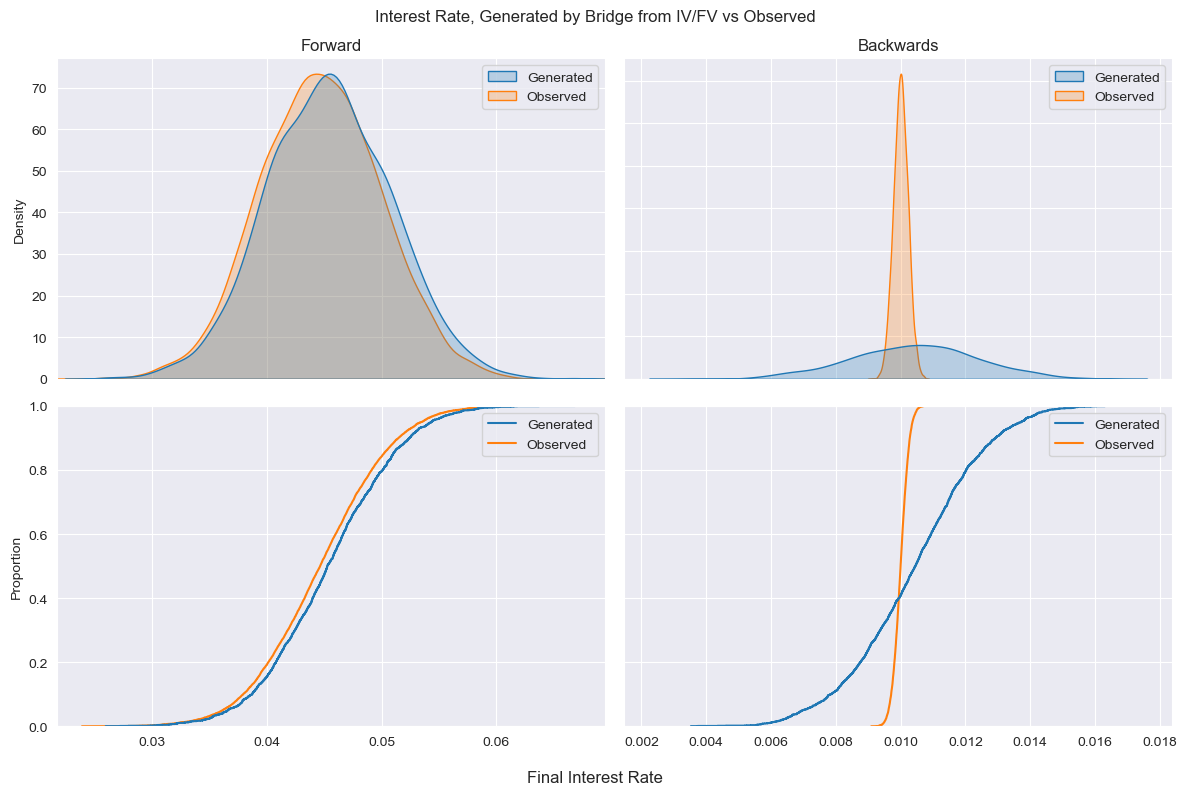

In [ ]:
def shareax(ax1,ax2):
    ax1.sharex(ax2)
    #ax1.sharey(ax2)
    ax1.relim()
    ax1.autoscale_view()
    ax1.label_outer()
    ax2.label_outer()

fdummies = SDESolve(u=u_forwards, pi=draw(frames['end'], k = 2000), N=60, direction='f')
f_final = [d[-1,0] for d in fdummies]
bdummies = SDESolve(u=u_backwards, pi=draw(frames['end'], k = 2000), N=60, direction='b')
d_initial = [reverse(d)[0,0] for d in bdummies]

fig, axes = plt.subplots(2,2,figsize = (12,8))
fig.set_layout_engine('tight')
sb.set_style("darkgrid")
sb.kdeplot({'Generated': f_final,'Observed':end_data}, ax=axes[0,0], fill=True, common_norm=False);
sb.ecdfplot({'Generated': f_final,'Observed':end_data}, ax = axes[1,0])
sb.kdeplot({'Generated': d_initial,'Observed':start_data}, ax=axes[0,1],fill=True, common_norm=False,);
sb.ecdfplot({'Generated': d_initial,'Observed':start_data}, ax = axes[1,1])
fig.supxlabel('Final Interest Rate');
fig.suptitle('Interest Rate, Generated by Bridge from IV/FV vs Observed')
shareax(axes[0,0],axes[1,0])
shareax(axes[1,1],axes[0,1])
axes[0,0].set_title('Forward / Final from Initial');
axes[0,1].set_title('Backwards / Initial from Final');
plt.show()


# Thoughts
The system converges nicely to a forward estimator that gives solid results, but the backwards NN isn't quite capable of pulling the distribution in line, though it is roughly correct. This could have to do with a number of issues, ranging from the size od the NN, training time, or discretization issues (consider that the NN has to contend with the constant gaussian noise, and the step size is rather large during the bridging training, the distribution is still far too wide for this to be the sole issue however.).

While the Vasicek Model is trivially calibrated, this still demonstrates that for some less easily calibrated model, which is difficult to tune on only end points, but easily tuned if you have sample paths the IPML schrodinger bridge may be capable of simaltaneously training the model and generating those paths.